# Preliminaries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
random_seed = 131313 # for reproducibility

## Load Dataset

In [3]:
X = pd.read_csv("ToyDataset.data")

X

,Sex,Paid Loans,Income,Country,Label
0,M,1,Low,US,0
1,M,1,Low,Other,0
2,F,1,Low,US,0
3,F,1,Low,Other,0
4,M,1,Medium,US,1
...,...,...,...,...,...
123,F,1,Medium,Other,0
124,F,2,Low,US,1
125,F,2,Low,Other,0
126,F,2,Medium,US,1


In [4]:
df = X

## Model training and test

In [5]:
y = df['Label']
X = df.drop('Label', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='Label')
model.predict(X_test.iloc[:100, :])

CPU times: total: 0 ns
Wall time: 8.65 ms


array([1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 1.])

In [7]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        24

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



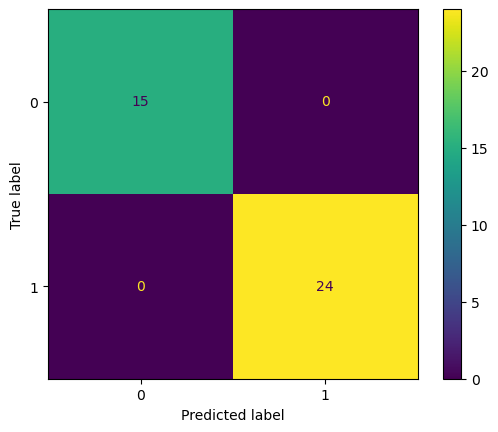

In [8]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and atomic correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [9]:
#Uncomment if you want to find new rules with different support

start_time = time.time()
ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='Sex',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = False
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 402.10it/s]

Number of frequent itemsets for affected: {'F': 19, 'M': 11}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]

Number of subgroups in the intersection: 11
Number of frequent itemsets for the unaffected: 67
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]

Computing correctenesses for all valid if-thens.



100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 191.89it/s]

Number of if-thens: 29


In [10]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
# rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [11]:
comparators = facts.feature_change_builder(
    X_test,
    num_cols=num_features,
    cate_cols=cate_features,
    ord_cols=[],
    feature_weights={},
    num_normalization=False
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics.

In [12]:
stats["valid-if-thens-time"] = end_time - start_time
stats["triples-no"] = len(ifthens_coverage_correctness)
stats["subgroup-no"] = len(rules_by_if)

In [13]:
params.featureChanges

{'Sex': functools.partial(<function feature_change_builder.<locals>.feature_change_cate at 0x000001C43264DEE0>, weight=1),
 ' Income': functools.partial(<function feature_change_builder.<locals>.feature_change_cate at 0x000001C43264DEE0>, weight=1),
 ' Country': functools.partial(<function feature_change_builder.<locals>.feature_change_cate at 0x000001C43264DEE0>, weight=1),
 ' Paid Loans': functools.partial(<function feature_change_builder.<locals>.feature_change_num at 0x000001C43264DD00>, weight=1)}

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [14]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="Sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If  Country = Other,  Income = Low:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Country = US,  Income = Medium with effectiveness 100.00%.
		Aggregate cost of the above recourses = 2.00
	Bias against F due to Equal Effectiveness. Unfairness score = 1.
If  Country = Other,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00%.
		Aggregate cost of the above recourses = 2.00
	Bias against F due to Equal Effectiveness. Unfairness score = 1.
If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00%.
		Make  Paid Loans

### Equal Choice for Recourse

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="Sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If  Country = US,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00%.
		Make  Country = Other,  Income = Medium with effectiveness 100.00%.
		Make  Income = Medium with effectiveness 100.00%.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00%.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00%.
		Aggregate cost of the above recourses = -5.00
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Paid Loans = 2 with effectiveness 100.00%.
		Make  Income = Medium with effectiveness 100.00%.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00%.
		Aggregate cost of the above recourses = -3.00
	Bias against F due to Equal Effectiveness. Unfairness score = 2.
If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00%.
		Make  Income = Medium with effective

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [16]:
start_time = time.time()
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="Sex", params=params)
end_time = time.time()

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 131.76it/s]


In [17]:
stats["cumulative-time"] = end_time - start_time

### Equal (Conditional) Mean Recourse

In [28]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 27.27% covered out of 11
		Make  Income = Medium with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost =

### Equal Effectiveness

If  Country = Other:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Country = US with effectiveness 57.14% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.57
	Bias against M due to Equal Effectiveness. Unfairness score = 0.571.
	Cumulative effectiveness plot for the above recourses:


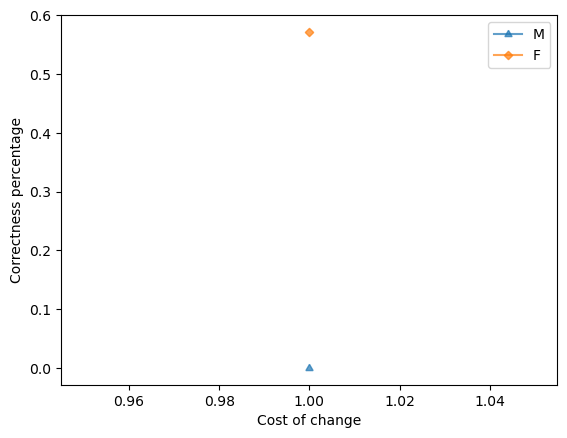

If  Paid Loans = 1:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Paid Loans = 2 with effectiveness 66.67% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.67
	Bias against F due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


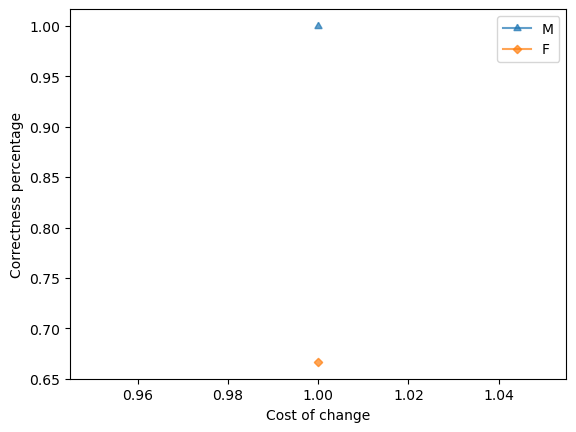

If  Income = Low:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Income = Medium with effectiveness 66.67% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.67
	Bias against F due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


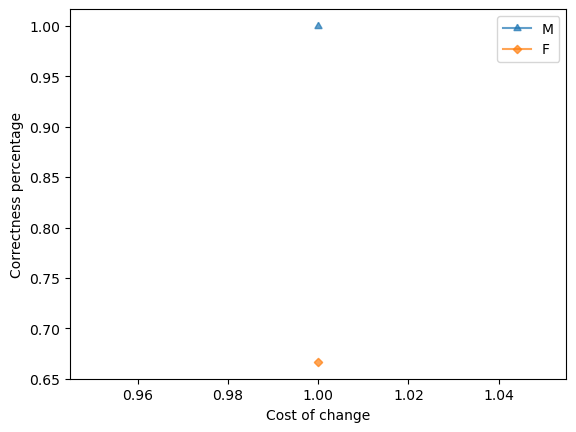

If  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Income = Medium with effectiveness 57.14% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 57.14% and counterfactual cost = 1.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


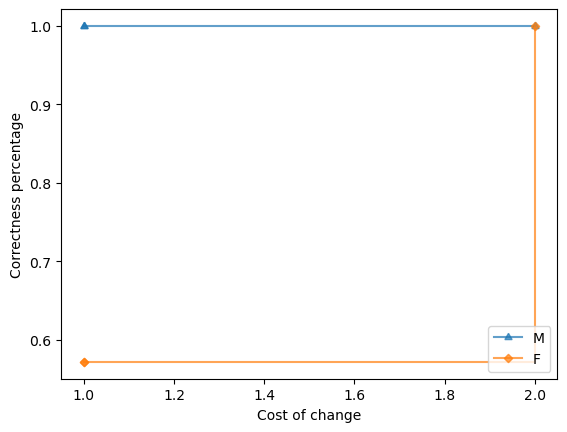

If  Country = US:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


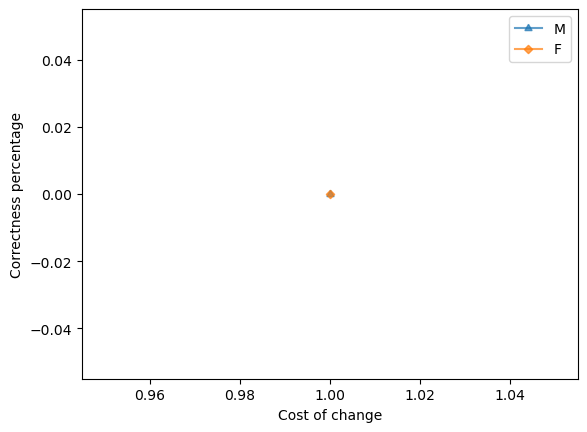

If  Country = US,  Income = Low:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


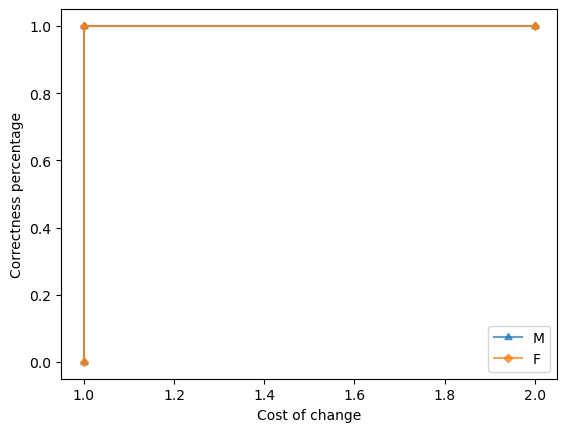

If  Country = US,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


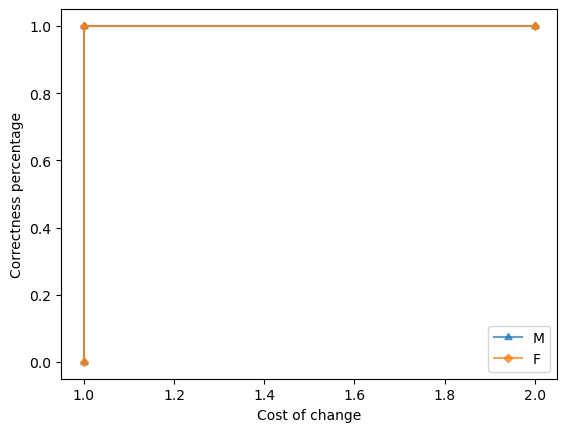

If  Country = US,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterf

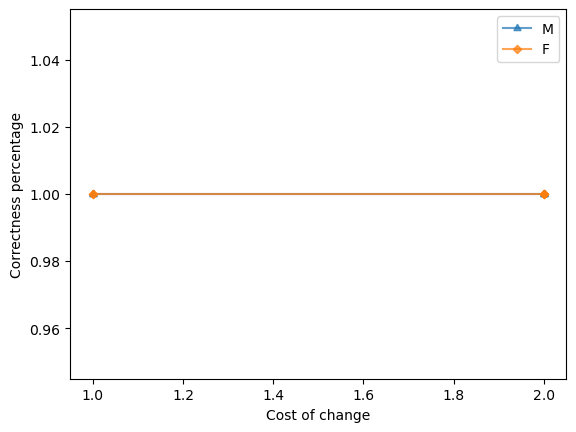

If  Country = Other,  Income = Low:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Income = Medium with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


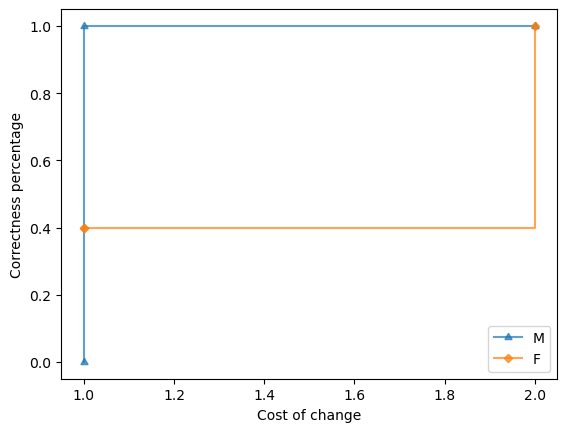

If  Country = Other,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Paid Loans = 2 with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	No bias!
	Cumulative effectiveness plot for the above recourses:


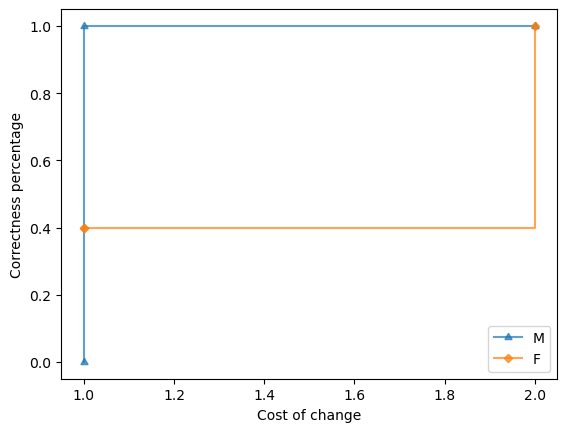

If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 27.27% covered out of 11
		Make  Income = Medium with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost =

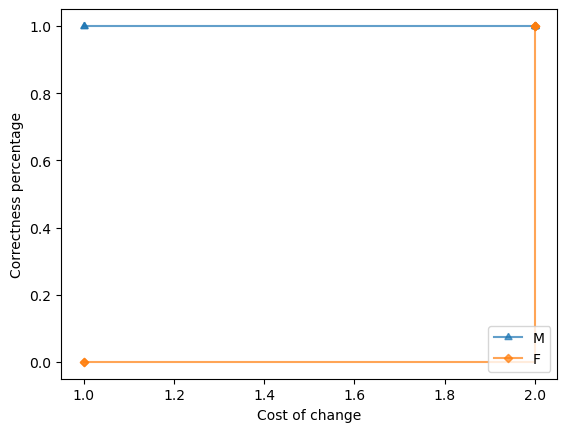

In [19]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 27.27% covered out of 11
		Make  Income = Medium with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against F due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


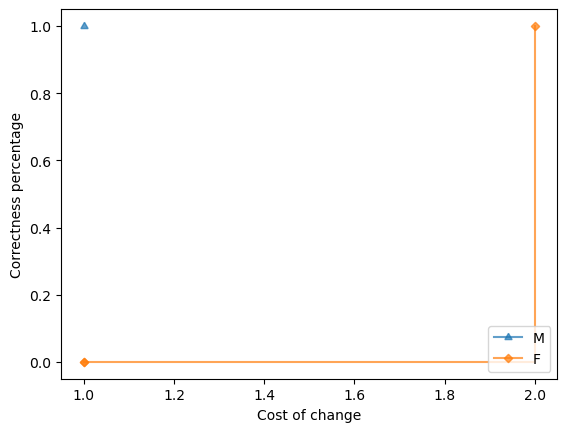

If  Country = Other:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Country = US with effectiveness 57.14% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against M due to Equal Effectiveness. Unfairness score = inf.
	Cumulative effectiveness plot for the above recourses:


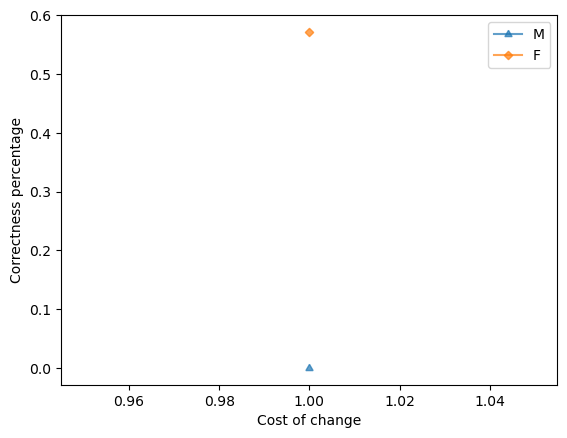

In [20]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If  Country = Other:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Country = US with effectiveness 57.14% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.57
	Bias against M due to Equal Effectiveness. Unfairness score = 0.571.
	Cumulative effectiveness plot for the above recourses:


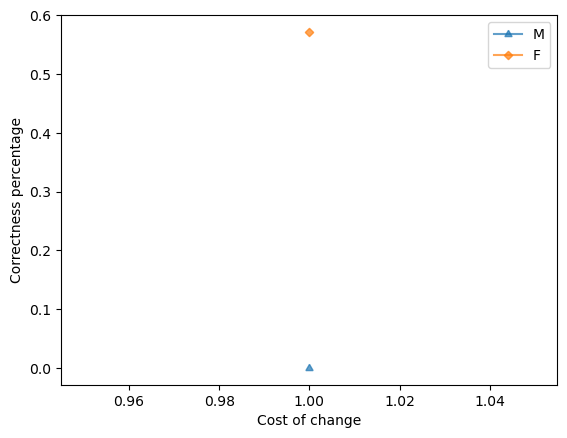

If  Paid Loans = 1:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Paid Loans = 2 with effectiveness 66.67% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.67
	Bias against F due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


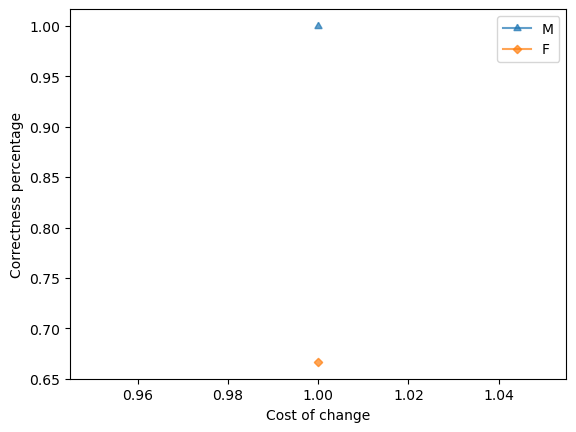

If  Income = Low:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Income = Medium with effectiveness 66.67% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.67
	Bias against F due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


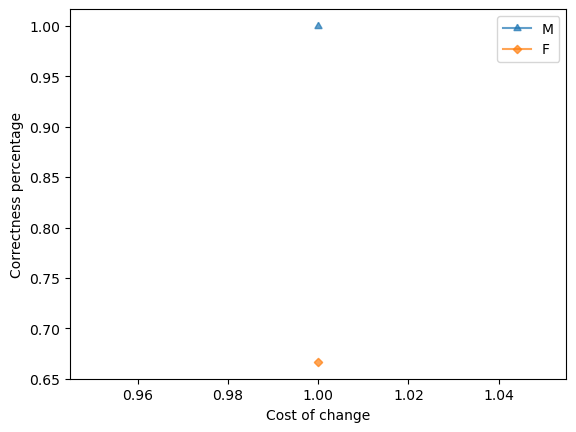

In [21]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If  Country = Other,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 27.27% covered out of 11
		Make  Income = Medium with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 

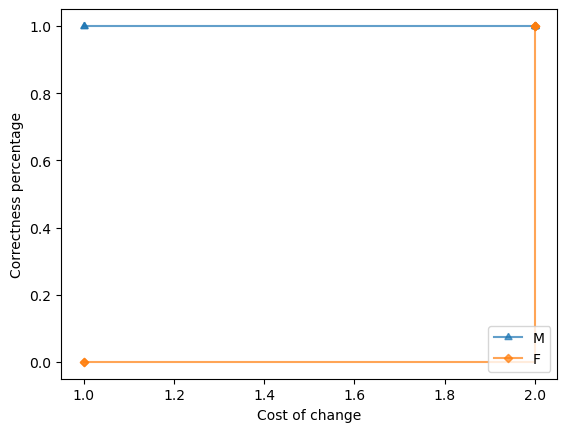

If  Country = Other,  Income = Low:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Income = Medium with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.72.
	Cumulative effectiveness plot for the above recourses:


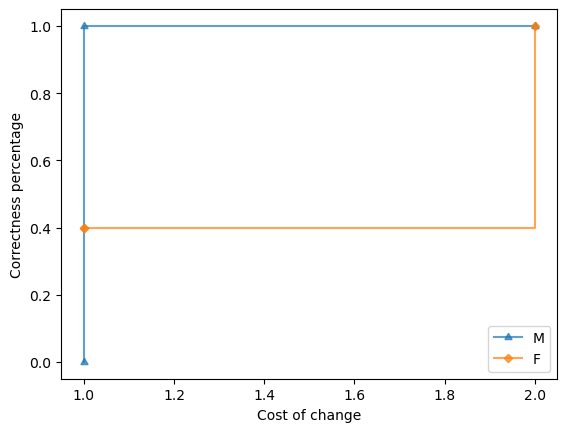

If  Country = Other,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 45.45% covered out of 11
		Make  Paid Loans = 2 with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US with effectiveness 40.00% and counterfactual cost = 1.0.
		Make  Country = US,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.72.
	Cumulative effectiveness plot for the above recourses:


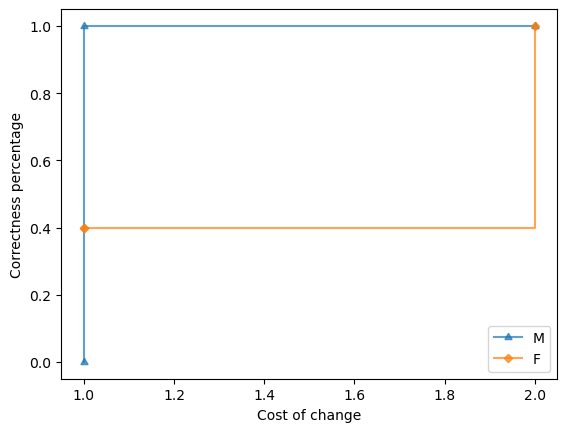

If  Country = Other:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = US with effectiveness 0.00% and counterfactual cost = 1.0.
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Country = US with effectiveness 57.14% and counterfactual cost = 1.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.71.
	Cumulative effectiveness plot for the above recourses:


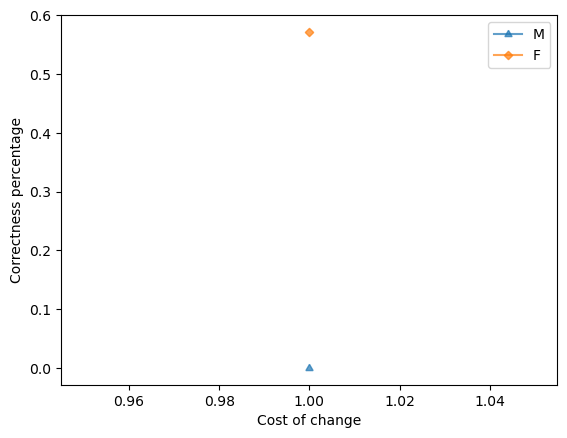

If  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 63.64% covered out of 11
		Make  Income = Medium with effectiveness 57.14% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 57.14% and counterfactual cost = 1.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.68.
	Cumulative effectiveness plot for the above recourses:


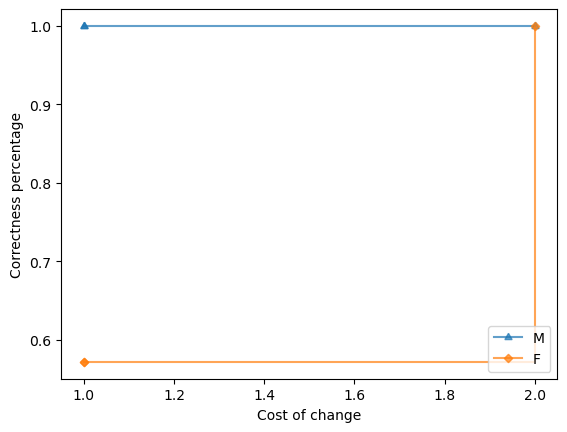

If  Paid Loans = 1:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Paid Loans = 2 with effectiveness 66.67% and counterfactual cost = 1.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.55.
	Cumulative effectiveness plot for the above recourses:


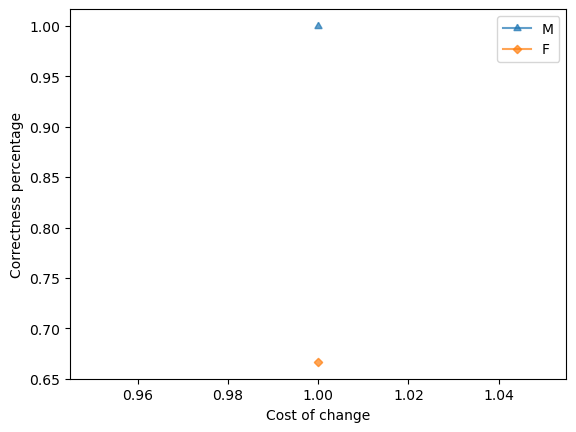

If  Income = Low:
	Protected Subgroup 'M', 100.00% covered out of 4
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup 'F', 81.82% covered out of 11
		Make  Income = Medium with effectiveness 66.67% and counterfactual cost = 1.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.55.
	Cumulative effectiveness plot for the above recourses:


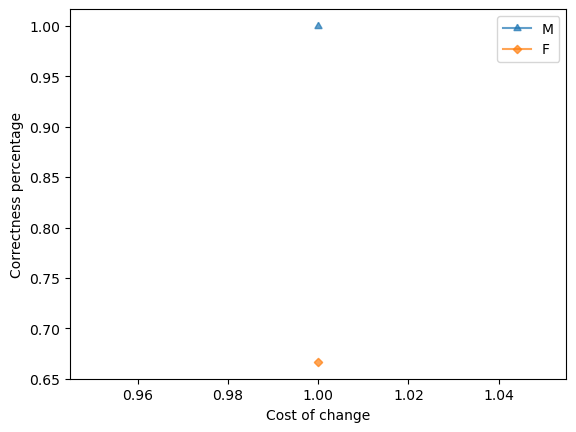

If  Country = US:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.0.
	Cumulative effectiveness plot for the above recourses:


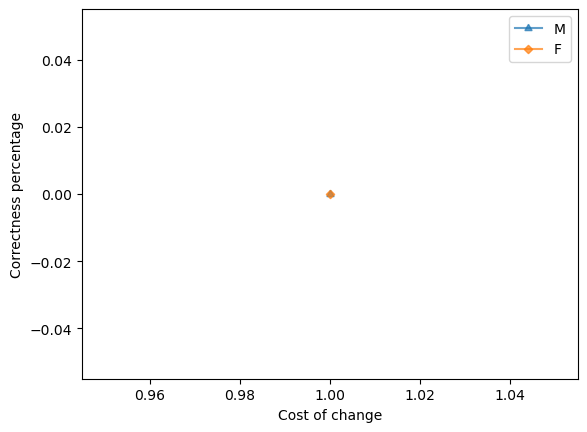

If  Country = US,  Income = Low:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.0.
	Cumulative effectiveness plot for the above recourses:


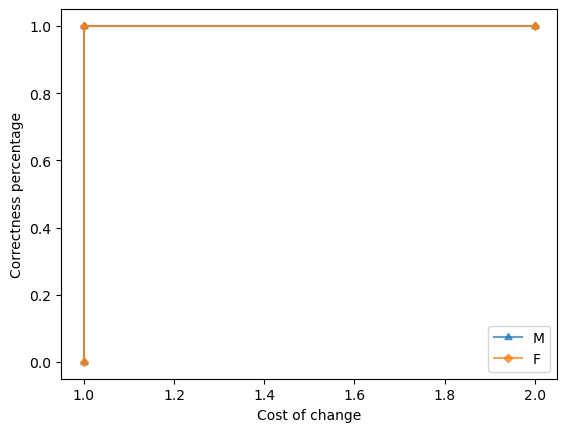

If  Country = US,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Country = Other with effectiveness 0.00% and counterfactual cost = 1.0.
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 0.0.
	Cumulative effectiveness plot for the above recourses:


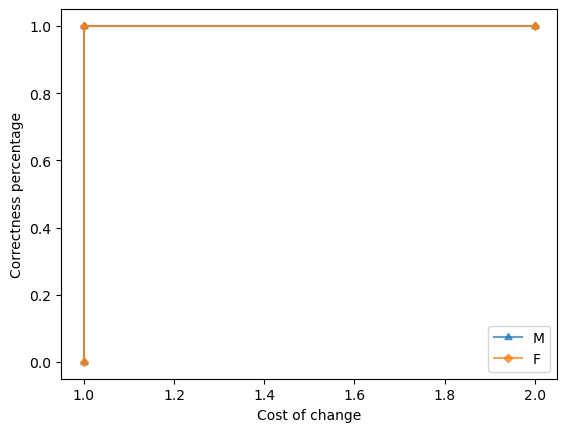

If  Country = US,  Income = Low,  Paid Loans = 1:
	Protected Subgroup 'M', 50.00% covered out of 4
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup 'F', 36.36% covered out of 11
		Make  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Income = Medium with effectiveness 100.00% and counterfactual cost = 1.0.
		Make  Country = Other,  Income = Medium with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Country = Other,  Paid Loans = 2 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make  Income = Medium,  Pa

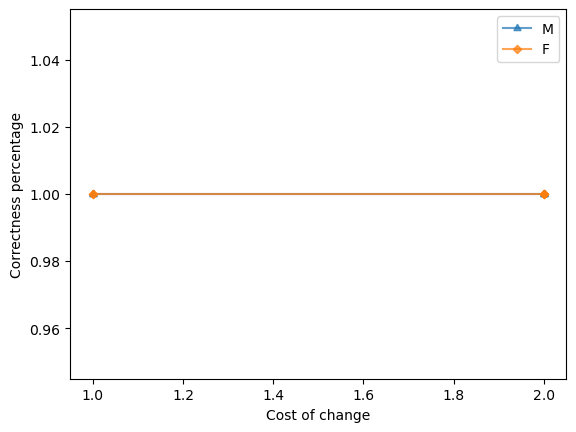

In [22]:
affected_pop_sizes = {sg: ((X_test["Sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["Sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

In [23]:
end_time = time.time()

In [24]:
end_time - start_time

5.112441301345825

In [25]:
stats["metrics-time"] = end_time - start_time

In [26]:
stats

{'freq-itemsets-no': {'F': 19, 'M': 11},
 'inter-groups-no': 11,
 'unaff-freq-itemsets-no': 67,
 'valid-if-thens-time': 0.179185152053833,
 'triples-no': 29,
 'subgroup-no': 11,
 'cumulative-time': 0.08903932571411133,
 'metrics-time': 5.112441301345825}

In [27]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

5.3806657791137695